# My implementation of DiffEdit: Diffusion-based semantic image editing with mask guidance

Given an image, a description and a new description, DiffEdit attempts to alter the image to match the new description by generating a mask of the difference between the descriptions and performing local diffusion image generation on the masked area of the input image.

![figure1 from diffedit paper](diffeditfigure1.PNG)

Figure taken from the DiffEdit paper [https://arxiv.org/abs/2210.11427](https://arxiv.org/abs/2210.11427)

## Imports and Setup

In [1]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import DDIMScheduler
from tqdm.auto import tqdm
from IPython.display import display
from PIL import Image
from torchvision import transforms as tfms
import matplotlib.pyplot as plt

In [3]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to(torch_device)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to(torch_device)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to(torch_device)
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
vae_magic = 0.18215

## My Implementations

In [4]:
def text2emb(prompt):
    max_length = tokenizer.model_max_length
    tokens = tokenizer(prompt, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
    return text_encoder(tokens.input_ids.to(torch_device))[0].half()

def img2lat(input_img):
    tensor = tfms.ToTensor()(input_img).half().unsqueeze(0).to(torch_device)*2-1
    with torch.no_grad():
        latent = vae.encode(tensor)
    latent = latent.latent_dist.sample() * vae_magic
    return latent.to(torch_device)

def lats2imgs(latents):
    with torch.no_grad():
        decoded = vae.decode(latents * 1 / vae_magic).sample
    images = []
    for x in decoded:
        image = (x / 2 + 0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
        images.append(Image.fromarray((image*255).round().astype("uint8")))
    return images

def create_embeddings(prompt, new_prompt, bs=3):
    emb = text2emb(prompt).repeat(bs, 1, 1)
    new_emb = text2emb(new_prompt).repeat(bs, 1, 1)
    return torch.cat([emb, new_emb])

def process_editing_mask(p1, p2, clamp=2):
    diff = (p1-p2).abs_().sum(dim=1)#.pow(2).sum(dim=1).pow(0.5)
    diff = diff.clamp(0, diff.mean() * clamp)          # remove extreme values in noise predictions
    diff = diff.mean(0)                                # and stabilize the effect by averaging spatial differences over a set of n input noises, with n = 10 in our default configuration
    diff = (diff - diff.min()) / diff.max()            # The result is then rescaled to the range [0, 1]
    mask = torch.where(diff > 0.5, 1, 0)               # and binarized with a threshold, which we set to 0.5 by default
    return mask

def compute_editing_mask(prompt, new_prompt, start_img, seed=42, n=10, noise=0.5, steps=50, clamp=3):
    scheduler.set_timesteps(steps)
    ts = scheduler.timesteps[int(steps * noise)]       # we use a Gaussian noise with strength 50%
    embs = create_embeddings(prompt, new_prompt, bs=n)
    latents = img2lat(start_img).repeat(n, 1, 1, 1)
    noise = torch.randn_like(latents)
    noised_latents = scheduler.add_noise(latents, noise, timesteps=ts)
    inp = scheduler.scale_model_input(torch.cat([noised_latents] * 2), ts)

    with torch.no_grad(): pred = unet(inp, ts, encoder_hidden_states=embs).sample
    orginal, new = pred.chunk(2)
    mask = process_editing_mask(orginal, new, clamp=clamp)
    return mask

def diffedit(prompt, new_prompt, start_img, bs=1, g=7.5, seed=1, n=10, noise=0.5, er=0.6, steps=50, clamp=3):
    torch.manual_seed(seed)
    scheduler.set_timesteps(steps)
    start_step = int(steps * (1 - er))
    
    mask = compute_editing_mask(prompt, new_prompt, start_img, seed=seed, n=n, steps=steps, noise=noise, clamp=clamp).repeat(bs, 1, 1, 1)
    embs = create_embeddings(new_prompt, "", bs=bs)
    latents = img2lat(start_img).repeat(bs, 1, 1, 1)
    original = latents[0].clone()
    noise = torch.randn_like(latents)
    latents = scheduler.add_noise(latents, noise, timesteps=scheduler.timesteps[start_step])
    
    for i, ts in enumerate(tqdm(scheduler.timesteps)):
        if i >= start_step:
            inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
            with torch.no_grad(): 
                pred = unet(inp, ts, encoder_hidden_states=embs).sample
            pos, neg = pred.chunk(2)
            pred = neg + g * (pos - neg)
            noised_original = scheduler.add_noise(original, noise, timesteps=ts)
            latents = mask * latents  + (1 - mask) * noised_original
            latents = scheduler.step(pred, ts, latents).prev_sample
    images = lats2imgs(latents)
    return images

## Example Input

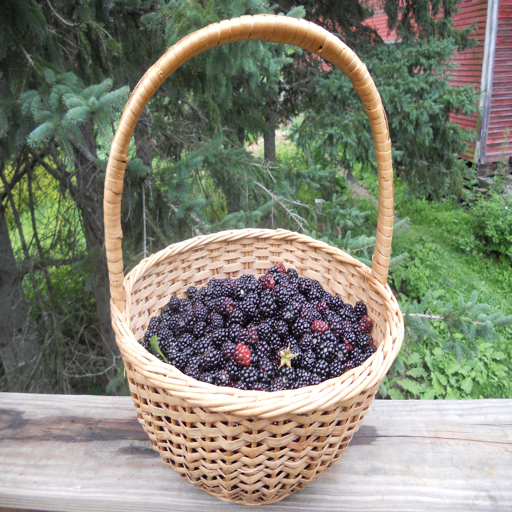

In [5]:
input_img = Image.open('blackberries.jpeg').resize((512, 512))
display(input_img)

## Example Mask

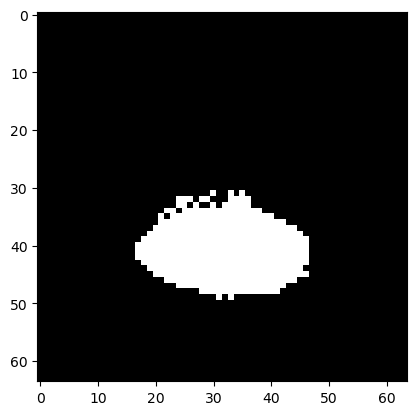

In [6]:
description = "a basket filled with blackberries sitting on top of a wooden table, cottage hippie naturalist"
new_description = "a basket filled with strawberries sitting on top of a wooden table, cottage hippie naturalist"
mask = compute_editing_mask(prompt = description, 
                            new_prompt = new_description, 
                            start_img = input_img)
plt.imshow(mask.cpu(), cmap='gray');

## Example Output

  0%|          | 0/50 [00:00<?, ?it/s]

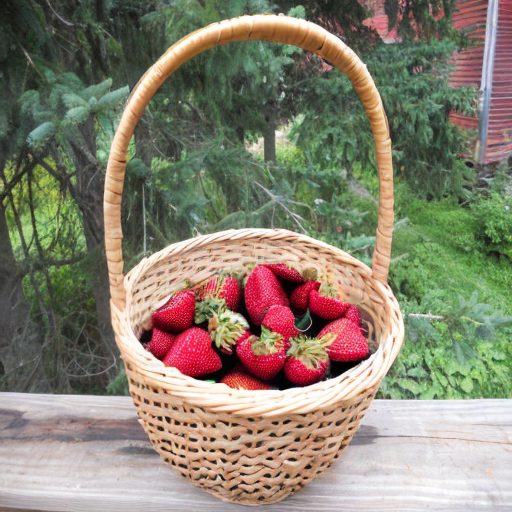

In [8]:
imgs = diffedit(prompt = description, 
                new_prompt = new_description, 
                start_img = input_img, 
                er=0.9)
for img in imgs: display(img)